<img src = "https://thumbs2.imgbox.com/32/93/xRH3CBEG_t.png" width="250">

# Cálculo da Perda Esperada
---


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score

from funcoes.funcoes import *

import joblib

import warnings
warnings.filterwarnings("ignore")

In [12]:
LC_defaults = pd.read_csv('dados/dados_WoE_VI_LGD_EAD_regressao.csv')

In [13]:
modelo_lgd1 = joblib.load('modelos/modelo_lgd_v1.sav')
modelo_lgd2 = joblib.load('modelos/modelo_lgd_v2.sav')
modelo_ead  = joblib.load('modelos/modelo_ead_v1.sav')
modelo_pd   = joblib.load('modelos/modelo_pd_v1.sav')

In [14]:
LC_defaults.head()

,funded_amnt,term,int_rate,annual_inc,dti,inq_last_6mths,revol_util,tot_cur_bal,mths_since_rcnt_il,total_bal_il,...,initial_list_status:w,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,taxa_recuperacao,taxa_recuperacao_0_1,fator_conversao_credito
0,9000,36,5.32,58000.0,10.39,0,4.2,7063,26,1982,...,1,0,0,0,0,0,0,0.0,0,0.0
1,8300,36,9.44,54000.0,16.91,0,30.7,26958,4,21058,...,1,1,0,0,0,0,0,0.0,0,0.0
2,4225,36,17.57,35000.0,29.25,2,82.0,35796,0,0,...,0,0,0,1,0,0,0,0.0,0,0.0
3,28000,36,7.49,425000.0,8.97,0,28.0,503070,0,0,...,0,0,0,0,0,0,0,0.0,0,0.0
4,3000,36,5.31,72000.0,14.60,0,3.0,305664,3,28880,...,1,0,0,0,0,0,0,0.0,0,0.0


#### LGD

In [17]:
# separando dados
X = LC_defaults.drop(['target', 'taxa_recuperacao', 'taxa_recuperacao_0_1', 'fator_conversao_credito', 'funded_amnt', 'total_rec_prncp', 'recoveries'], axis = 1)

In [18]:
# Combinando os valores previstos do modelo parte 1 (regressão logística) e do modelo parte 2 (regressão linear)
# para calcular a taxa de recuperação final estimada
LC_defaults['taxa_recuperacao_1'] = modelo_lgd1.model.predict(X)
LC_defaults['taxa_recuperacao_2'] = modelo_lgd2.predict(X)

LC_defaults['taxa_recuperacao_final'] = LC_defaults['taxa_recuperacao_1'] * LC_defaults['taxa_recuperacao_2']

In [19]:
LC_defaults['taxa_recuperacao_final'] = np.where(LC_defaults['taxa_recuperacao_final'] < 0, 0, LC_defaults['taxa_recuperacao_final'])
LC_defaults['taxa_recuperacao_final'] = np.where(LC_defaults['taxa_recuperacao_final'] > 1, 1, LC_defaults['taxa_recuperacao_final'])

In [20]:
# Calcula-se a LGD estimada. A LGD estimada é igual a 1 - taxa de recuperação estimada
LC_defaults['LGD'] = 1 - LC_defaults['taxa_recuperacao_final']

LC_defaults['LGD'].describe()

count    877648.000000
mean          0.946048
std           0.055340
min           0.546411
25%           0.893635
50%           1.000000
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

#### EAD

In [32]:
X2 = LC_defaults.drop(['target', 'taxa_recuperacao','taxa_recuperacao_0_1','fator_conversao_credito', 'LGD', 'taxa_recuperacao_final', 'taxa_recuperacao_1', 'taxa_recuperacao_2'], axis = 1)

In [34]:
# Aplica-se o modelo EAD para calcular o fator de conversão de crédito estimado
LC_defaults['CCF'] = modelo_ead.predict(X2)

LC_defaults['CCF'] = np.where(LC_defaults['CCF'] < 0, 0, LC_defaults['CCF'])
LC_defaults['CCF'] = np.where(LC_defaults['CCF'] > 1, 1, LC_defaults['CCF'])

In [36]:
# Calcula-se o EAD estimado. O EAD estimado é igual ao CCF estimado multiplicado pelo valor financiado
LC_defaults['EAD'] = LC_defaults['CCF'] * LC_defaults['funded_amnt']

LC_defaults['EAD'].describe()

count    877648.000000
mean       1581.203176
std        3400.674334
min           0.000000
25%         111.482578
50%         517.068132
75%        1484.368546
max       40000.000000
Name: EAD, dtype: float64

#### PD

In [55]:
LC_defaults_pd = pd.read_csv('dados/dados_WoE_VI_final.csv')

In [66]:
# aplica-se o modelo PD para calcular as probabilidades de default estimadas.
modelo_pd.predict_proba(LC_defaults_pd.drop(['loan_status', 'target', 'funded_amnt', 'total_rec_prncp','recoveries'], axis = 1))[: ][: , 0]

array([0.39892484, 0.10574108, 0.30274515, ..., 0.24496837, 0.59653926,
       0.07756227])

In [68]:
LC_defaults_pd['PD'] = modelo_pd.predict_proba(LC_defaults_pd.drop(['loan_status', 'target', 'funded_amnt', 'total_rec_prncp','recoveries'], axis = 1))[:][: , 0]

In [70]:
LC_defaults_pd['PD'].head()

0    0.398925
1    0.105741
2    0.302745
3    0.042795
4    0.107472
Name: PD, dtype: float64

In [71]:
LC_defaults_pd['PD'].describe()

count    877648.000000
mean          0.318410
std           0.240625
min           0.000262
25%           0.118434
50%           0.255322
75%           0.477564
max           0.999768
Name: PD, dtype: float64

### Perda Esperada

In [72]:
# junta-se os dataframes onde calculamos LGD e EAD e o dataframe onde calculamos PD ao longo das colunas
LC_defaults_new = pd.concat([LC_defaults, LC_defaults_pd], axis = 1)

In [73]:
LC_defaults_new.shape

(877648, 134)

In [74]:
LC_defaults_new.head()

,funded_amnt,term,int_rate,annual_inc,dti,inq_last_6mths,revol_util,tot_cur_bal,mths_since_rcnt_il,total_bal_il,...,total_rev_hi_lim:20000-40000,total_rev_hi_lim:40000-60000,total_rev_hi_lim:60000-80000,total_rev_hi_lim:80000-100000,funded_amnt,total_rec_prncp,loan_status,recoveries,target,PD
0,9000,36,5.32,58000.0,10.39,0,4.2,7063,26,1982,...,0,0,0,0,9000.0,9000.00,Fully Paid,0.0,1,0.398925
1,8300,36,9.44,54000.0,16.91,0,30.7,26958,4,21058,...,0,0,0,0,8300.0,8300.00,Fully Paid,0.0,1,0.105741
2,4225,36,17.57,35000.0,29.25,2,82.0,35796,0,0,...,0,0,0,0,4225.0,4225.00,Fully Paid,0.0,1,0.302745
3,28000,36,7.49,425000.0,8.97,0,28.0,503070,0,0,...,0,0,1,0,28000.0,28000.00,Fully Paid,0.0,1,0.042795
4,3000,36,5.31,72000.0,14.60,0,3.0,305664,3,28880,...,0,1,0,0,3000.0,1861.51,Current,0.0,1,0.107472


In [75]:
# # calculando a Perda Esperada. EL = PD * LGD * EAD
LC_defaults_new['EL'] = LC_defaults_new['PD'] * LC_defaults_new['LGD'] * LC_defaults_new['EAD']

In [76]:
LC_defaults_new['EL'].describe()

count    877648.000000
mean        592.286591
std        1639.462039
min           0.000000
25%           9.430153
50%         108.249487
75%         461.909622
max       37975.992326
Name: EL, dtype: float64

In [77]:
LC_defaults_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,9000,9000.0,0.398925,1.000000,280.664364,111.963986
1,8300,8300.0,0.105741,0.896422,414.463541,39.286418
2,4225,4225.0,0.302745,0.899318,607.859910,165.498450
3,28000,28000.0,0.042795,1.000000,0.000000,0.000000
4,3000,3000.0,0.107472,1.000000,151.103670,16.239469


In [102]:
LC_defaults_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,877648.000000,877648.000000
mean,15345.913396,15345.913396
std,9466.009368,9466.009368
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,13000.000000,13000.000000
75%,20000.000000,20000.000000
max,40000.000000,40000.000000


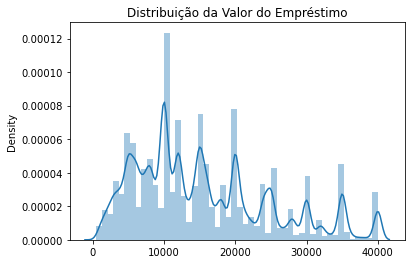

In [94]:
plt.title('Distribuição da Valor do Empréstimo')
sns.distplot(LC_defaults_new.funded_amnt);

In [79]:
# Perda Total Esperada para todos os empréstimos
LC_defaults_new['EL'].sum()

519819141.8860071

In [97]:
# Valor total financiado para todos os empréstimos
LC_defaults_new['funded_amnt'].sum()

funded_amnt    1.346831e+10
funded_amnt    1.346831e+10
dtype: float64

In [96]:
# Perda total esperada como proporção do valor total financiado para todos os empréstimos
LC_defaults_new['EL'].sum() / LC_defaults_new['funded_amnt'].sum()

funded_amnt    0.038596
funded_amnt    0.038596
dtype: float64

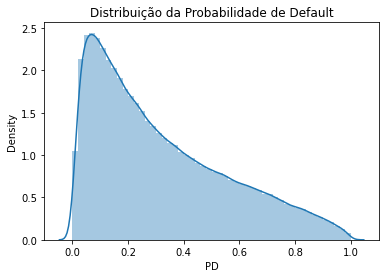

In [93]:
plt.title('Distribuição da Probabilidade de Default')
sns.distplot(LC_defaults_new.PD);

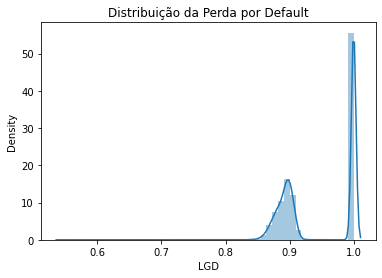

In [92]:
plt.title('Distribuição da Perda por Default')
sns.distplot(LC_defaults_new.LGD);

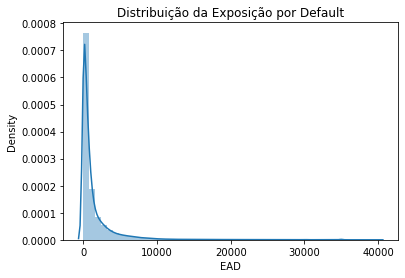

In [95]:
plt.title('Distribuição da Exposição por Default')
sns.distplot(LC_defaults_new.EAD);

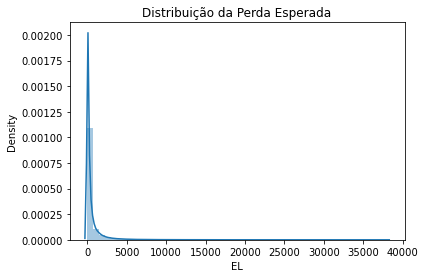

In [91]:
plt.title('Distribuição da Perda Esperada')
sns.distplot(LC_defaults_new.EL);

---